# TF2.0 Loader製作- Sampling

## 內容
    * 基本loader
    * batch
    * repeat
    * shuffle
    * filter

In [1]:
import tensorflow as tf
from functools import partial
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

**以tf.data.Dataset.from_generator這種loader類型示範**

先準備好一個data generator，會yield指定數量的數字

In [2]:
def f(rng):
    for i in range(rng):
        yield i

In [3]:
list(iter(f(3)))

[0, 1, 2]

---

## 最陽春的loader

In [4]:
d=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32)

In [5]:
%%time
for i,x in enumerate(d):
        pprint(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
Wall time: 24 ms


---

## Batch

In [6]:
'''直接開超過1就好'''
d=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(2)

In [7]:
%%time
for i,x in enumerate(d):
    if i<3:
        pprint(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 5.], dtype=float32)>
Wall time: 123 ms


In [8]:
'''開越多會更快'''
d0=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(3)
d1=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(10)

In [9]:
%%time
for i,x in enumerate(d0):
    if i<3:
        pprint(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 7., 8.], dtype=float32)>
Wall time: 105 ms


In [10]:
%%time
for i,x in enumerate(d1):
    if i<3:
        pprint(x)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)>
<tf.Tensor: shape=(10,), dtype=float32, numpy=array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.], dtype=float32)>
<tf.Tensor: shape=(10,), dtype=float32, numpy=array([20., 21., 22., 23., 24., 25., 26., 27., 28., 29.], dtype=float32)>
Wall time: 84 ms


In [11]:
'''到某個程度後邊際效應遞減'''
d0=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(10)
d1=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(100)
d2=tf.data.Dataset.from_generator(f,args=[1000],output_types=tf.float32).batch(200)

In [12]:
%%time
for i,x in enumerate(d0):
    pass

Wall time: 78 ms


In [13]:
%%time
for i,x in enumerate(d1):
    pass

Wall time: 72 ms


In [15]:
%%time
for i,x in enumerate(d2):
    pass

Wall time: 66 ms


In [16]:
d1=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).batch(2)
d2=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).batch(2,drop_remainder=True)

In [17]:
%%time
'''如果長度不能被batch size除盡，會有殘量'''
for i,x in enumerate(d1):
    pprint(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>
Wall time: 19 ms


In [18]:
%%time
'''drop_remainder會把殘量丟掉，適合某些長度需要一致的場合'''
for i,x in enumerate(d2):
    pprint(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
Wall time: 19 ms


---

## Repeat

In [19]:
d=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).repeat(2)

In [20]:
%%time
'''把指定的loader重複數次'''
for i,x in enumerate(d):
    pprint(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
Wall time: 19 ms


In [21]:
d=tf.data.Dataset.from_generator(f,args=[9],output_types=tf.float32).batch(3).repeat(2)

In [22]:
%%time
'''如果前面有batch過就，重複的項目也有batch'''
for i,x in enumerate(d):
    pprint(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 7., 8.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 2.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>
<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 7., 8.], dtype=float32)>
Wall time: 22 ms


In [23]:
d=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).batch(2).repeat(2)

In [24]:
%%time
'''如果前面有batch有殘量，重複的也有殘量'''
for i,x in enumerate(d):
    pprint(x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>
Wall time: 20 ms


In [30]:
d1=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).repeat(2).cache()
d2=tf.data.Dataset.from_generator(f,args=[3],output_types=tf.float32).cache().repeat(2)

In [32]:
%%time
'''如果先repeat 再cache,則兩次都是第一次速度'''
for i,x in enumerate(d1):
    pprint(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
Wall time: 8 ms


In [35]:
%%time
'''如果先cache再repeat,則第二次會被加速'''
for i,x in enumerate(d2):
    pprint(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
Wall time: 7 ms


---

## Shuffle

1. 把前buffer_size個先存起來
2. 從buffer_size裡面任抽一個輸出
3. 把buffer_size後面一個塞進buffer理
4. 重複2~3直到所有數字被抽出

[reference](https://zhuanlan.zhihu.com/p/42417456)

In [38]:
d1=tf.data.Dataset.from_generator(f,args=[5],output_types=tf.float32).shuffle(buffer_size=1)
'''如果buffer_size開1，就沒有亂抽到'''
for i,x in enumerate(d1):
    pprint(x)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
<tf.Tensor: shape=(), dtype=float32, numpy=4.0>


In [39]:
d2=tf.data.Dataset.from_generator(f,args=[5],output_types=tf.float32).shuffle(buffer_size=2)
'''如果buffer_size開2，有亂抽到'''
for i,x in enumerate(d2):
    pprint(x)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
<tf.Tensor: shape=(), dtype=float32, numpy=4.0>


In [40]:
'''可是這個buffer如果小於前面的資料數，那亂的程度就會受到影響'''
d=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().shuffle(3).batch(10).repeat(1000)

In [41]:
l=[]
for i in d:
    l.append(i)
a=tf.stack(l,axis=-1)

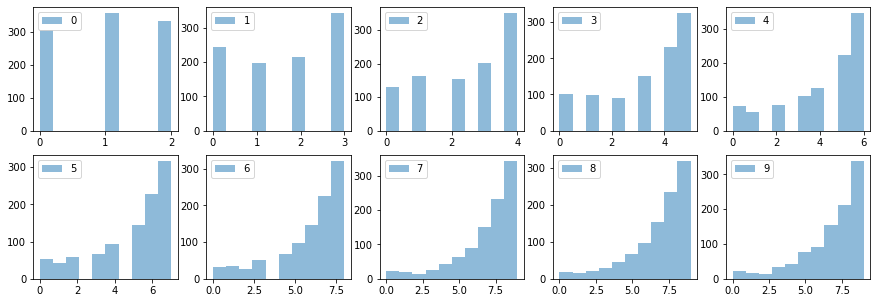

In [42]:
'''統計一下會發現，batch第一次抽到的可能性只落在三種選擇內，第二次的是4種，依此類推，越後面的越容易在更後面抽到'''
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [43]:
'''如果buffer數到了一定數量就比較好用一點'''
d=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().shuffle(8).batch(10).repeat(1000)

In [47]:
%%time
l=[]
for i in d:
    l.append(i)
a=tf.stack(l,axis=-1)

Wall time: 129 ms


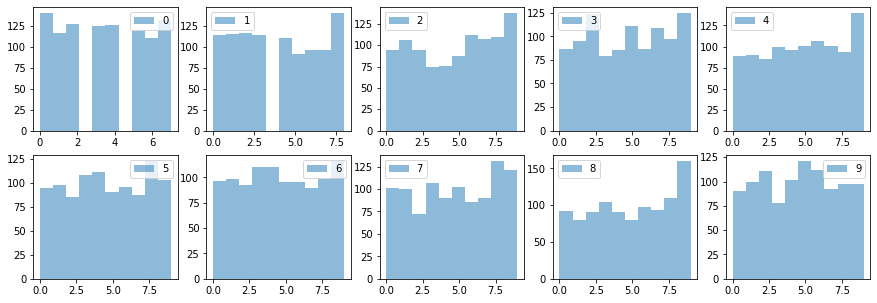

In [48]:
'''雖然前幾次的會不太隨機，但是後面的都很隨機'''
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [49]:
'''如果buffer開到滿就每次都隨機'''
d=tf.data.Dataset.from_generator(f,args=[10],output_types=tf.float32).cache().shuffle(10).batch(10).repeat(1000)

In [50]:
%%time
l=[]
for i in d:
    l.append(i)
a=tf.stack(l,axis=-1)

Wall time: 134 ms


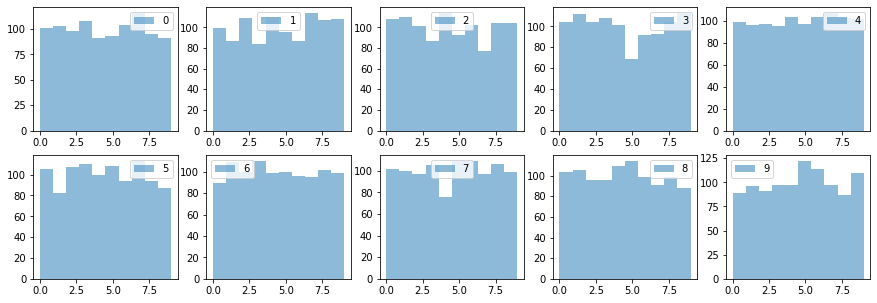

In [51]:
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [52]:
'''如果buffer開到滿就每次都隨機'''
d0=tf.data.Dataset.from_generator(f,args=[10000],output_types=tf.float32).cache().shuffle(2).batch(10000).repeat(1000)
d1=tf.data.Dataset.from_generator(f,args=[10000],output_types=tf.float32).cache().shuffle(2000).batch(10000).repeat(1000)
d2=tf.data.Dataset.from_generator(f,args=[10000],output_types=tf.float32).cache().shuffle(10000).batch(10000).repeat(1000)

In [53]:
%%time
for i in d0:
    pass

Wall time: 10.1 s


In [54]:
%%time
for i in d1:
    pass

Wall time: 10.2 s


In [55]:
%%time
for i in d2:
    pass

Wall time: 10.2 s


**重點是也沒有比只使用0.2倍的buffer_size慢**

**所以有想用shuffle記得buffer開滿，除非想依照class sample數量做balancing**

---

## Filter

In [56]:
'''篩選data'''
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).filter(lambda x:x>=3)

In [57]:
'''依指定判斷式比對'''
for i,x in enumerate(d):
    print(x)

tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)


In [58]:
'''篩選data'''
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).batch(2).filter(lambda x:x>2)

In [59]:
'''不能夠filter vector'''
try:
    for i,x in enumerate(d):
        print(x)
except:
    print("error")

error


---

## *較少用到的東西*

## Window

In [60]:
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).window(3)

In [61]:
%%time
'''把loader分成數組loaders，每組固定數量，可能用在切分class資料'''
for i,w in enumerate(d):
    print(i)
    for x in w:
        pprint(x)

0
<tf.Tensor: shape=(), dtype=float32, numpy=0.0>
<tf.Tensor: shape=(), dtype=float32, numpy=1.0>
<tf.Tensor: shape=(), dtype=float32, numpy=2.0>
1
<tf.Tensor: shape=(), dtype=float32, numpy=3.0>
<tf.Tensor: shape=(), dtype=float32, numpy=4.0>
<tf.Tensor: shape=(), dtype=float32, numpy=5.0>
Wall time: 41 ms


In [62]:
d=tf.data.Dataset.from_generator(f,args=[6],output_types=tf.float32).batch(2).window(2)

In [63]:
%%time
'''也可以先做好batch再分組'''
for i,w in enumerate(d):
    print(i)
    for x in w:
        pprint(x)

0
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>
1
<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 5.], dtype=float32)>
Wall time: 25 ms
